In [60]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
# import visualkeras

import datetime
import ephem

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pypalettes 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import json
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfea
import pyproj
import imageio.v2 as imageio
from io import BytesIO
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde, anderson_ksamp, cramervonmises_2samp
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import genextreme as gev
from scipy.stats import genpareto

import custom_functions as cf
import custom_for_model as cfm
import custom_generator as cgen
import pickle

from pyextremes import get_extremes
from pyextremes import plot_mean_residual_life
from pyextremes import EVA


palette = "Prism"
# cmap = pypalettes.load_cmap(palette, type="continuous", keep=[True, True, True, True, True, True, True])
palette_hex_list = pypalettes.get_hex(palette)
cmap_name = 'cmap_sealevel'
cmap_hex_list = [palette_hex_list[5],palette_hex_list[6],palette_hex_list[2],palette_hex_list[1],palette_hex_list[0]]
rgb_colors = [mcolors.hex2color(color) for color in cmap_hex_list]
cmap = LinearSegmentedColormap.from_list(cmap_name, rgb_colors, N=256)

MSE_map_hex_list = [palette_hex_list[5],palette_hex_list[4],palette_hex_list[2],palette_hex_list[1],palette_hex_list[0]]
MSE_colors = [mcolors.hex2color(color) for color in MSE_map_hex_list]
MSE_cmap = LinearSegmentedColormap.from_list(cmap_name, MSE_colors, N=256)


MSE_map_hex_list = [palette_hex_list[6],palette_hex_list[7],palette_hex_list[8],palette_hex_list[9],palette_hex_list[11]]
MSE_colors = [mcolors.hex2color(color) for color in MSE_map_hex_list]
MSE_cmap_2 = LinearSegmentedColormap.from_list(cmap_name, MSE_colors, N=256)

# Load settings
with open('settings.json', 'r') as file:
    settings = json.load(file)

2.16.1


In [61]:
nomi_corretti_architetture = ["FFNN","conv","conv3D","LSTM"]

In [62]:
import inspect 
from scipy.stats import genpareto
# print(inspect.getsource(genpareto.interval))

**Prism pypalette**<br>
<img src="Data/prism.png" alt="prism" width="300"/>

In [63]:
data_path= settings["data_path"]
output_path=settings["output_path"]
img_path=settings["img_path"]
local_data_path= os.getcwd()+'/Data/'

lat = settings["lat"]
lon = settings["lon"]

In [64]:
train_y_bounds = settings["train_y_bounds"]
train_month_start_end = settings["train_month_start_end"]
LSTM_recurrent_steps = settings["LSTM_recurrent_steps"]
ms_recurrent_steps = settings["ms_recurrent_steps"]
output_type = bool(settings["output_type"])
preprocess = settings["preprocess"]
kfold = bool(settings["kfold"])
folds_number = settings["folds_number"]

case_of_study = "NY"

if output_type:
   y_shape=2
else:
   y_shape=1

model_type = settings["model_type"]  # can be: conv, lstm, conv-lstm
# constrain n_recurrent_setps equal for each variable for lstm and conv-lstm
if (model_type=="lstm" or model_type=="conv-lstm"):
   LSTM_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)
   ms_recurrent_steps= max(LSTM_recurrent_steps,ms_recurrent_steps)

seed=42

In [ ]:
models_to_analyze = ["conv-lstm_5folds_bbox415_steps6_loss_mse","conv-lstm_5folds_bbox415_mewse1.25","conv-lstm_5folds_bbox415_mcql01","conv-lstm_5folds_bbox415_comploss"]

out_variables=["only tide", "storm surge"]

In [66]:
import itertools

# Definire le variabili
archit_to_analyze = ["dense","conv","conv3d","lstm"]
bbox_to_analyze = ["11","66","415","1015"]
steps_to_analyze = ["6","12","24","240"]
loss_to_analyze = ["mse","mcql2"]

# Generare tutte le combinazioni utilizzando itertools.product
combinations = itertools.product(archit_to_analyze, bbox_to_analyze, steps_to_analyze, loss_to_analyze)

# Creare la lista finale formattata
models_to_analyze = [f"{archit}_5folds_bbox{bbox}_steps{steps}_loss_{loss}" for archit, bbox, steps, loss in combinations]

# Stampa o usa l'array risultante
print(models_to_analyze)


['dense_5folds_bbox11_steps6_loss_mse', 'dense_5folds_bbox11_steps6_loss_mcql2', 'dense_5folds_bbox11_steps12_loss_mse', 'dense_5folds_bbox11_steps12_loss_mcql2', 'dense_5folds_bbox11_steps24_loss_mse', 'dense_5folds_bbox11_steps24_loss_mcql2', 'dense_5folds_bbox11_steps240_loss_mse', 'dense_5folds_bbox11_steps240_loss_mcql2', 'dense_5folds_bbox66_steps6_loss_mse', 'dense_5folds_bbox66_steps6_loss_mcql2', 'dense_5folds_bbox66_steps12_loss_mse', 'dense_5folds_bbox66_steps12_loss_mcql2', 'dense_5folds_bbox66_steps24_loss_mse', 'dense_5folds_bbox66_steps24_loss_mcql2', 'dense_5folds_bbox66_steps240_loss_mse', 'dense_5folds_bbox66_steps240_loss_mcql2', 'dense_5folds_bbox415_steps6_loss_mse', 'dense_5folds_bbox415_steps6_loss_mcql2', 'dense_5folds_bbox415_steps12_loss_mse', 'dense_5folds_bbox415_steps12_loss_mcql2', 'dense_5folds_bbox415_steps24_loss_mse', 'dense_5folds_bbox415_steps24_loss_mcql2', 'dense_5folds_bbox415_steps240_loss_mse', 'dense_5folds_bbox415_steps240_loss_mcql2', 'dense_

In [67]:
if preprocess=="normalize":
    with open(local_data_path+'kfold_global_min.pkl', 'rb') as file:
        kfold_global_min = pickle.load(file)
    with open(local_data_path+'kfold_global_max.pkl', 'rb') as file:
        kfold_global_max = pickle.load(file)

if preprocess=="standardize":
    with open(local_data_path+'kfold_global_mean_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_std_lat_'+str(lat)+'_lon_'+str(lon)+'.pkl', 'rb') as file:
        kfold_global_std = pickle.load(file)

if preprocess=="robustscaling":
    with open(local_data_path+'kfold_global_mean.pkl', 'rb') as file:
        kfold_global_mean = pickle.load(file)
    with open(local_data_path+'kfold_global_iqr.pkl', 'rb') as file:
        kfold_global_iqr = pickle.load(file)

## Regression metrics

## __________________________________________________________________________________________________________

In [68]:
def quantile_loss(y_true, y_pred, quantile):
    return tf.maximum(quantile * (y_true - y_pred), (1-quantile) * (y_pred - y_true))

def composite_quantile_loss(y_true, y_pred, quantiles):
    N = y_true.shape[0]
    K = len(quantiles)
    loss = 0
    for k in range(K):
        tau = quantiles[k]
        loss += tf.reduce_sum(quantile_loss(y_true, y_pred, tau)).numpy()
    composite_loss = loss / (N * K)
    return composite_loss

def ratio_of_99th_quantiles(y1, y2,quantile_for_ratio):
    q99_y1 = np.percentile(y1, quantile_for_ratio)
    q99_y2 = np.percentile(y2, quantile_for_ratio)
    if q99_y2 == 0:
        raise ValueError("y2 quantile is 0")
    return q99_y1 / q99_y2

quantiles = [0.75,0.8, 0.85, 0.9, 0.95, 0.999]
quantile_for_ratio=0.99


###### Define models to analyze

In [69]:
## what must be analized
which_set = "test"
which_var = "tide"

test_scores = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
val_scores = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
train_scores = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

test_scores_tide = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
val_scores_tide = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
train_scores_tide = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

test_scores_surge = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
val_scores_surge = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
train_scores_surge = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

test_scores_wl = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
val_scores_wl = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]
train_scores_wl = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

max_mse_heatmap = np.nan
min_mse_heatmap = np.nan
max_qloss_heatmap = np.nan
min_qloss_heatmap = np.nan
max_qratio_heatmap = np.nan
min_qratio_heatmap = np.nan

# Dizionario per salvare i DataFrame
dataframes_mse = {}
dataframes_qloss = {}
dataframes_qratio = {}

#n_matrici = len(archit_to_analyze)*len(loss_to_analyze)

n_matrici = len(archit_to_analyze)

# Creazione dei DataFrame
for i in range(n_matrici):
    for j in range(len(loss_to_analyze)):
        # Creare un DataFrame vuoto con nomi delle righe
        df_mse_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)
        df_qloss_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)
        df_qratio_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)

        for k in range(len(bbox_to_analyze)):
            for w in range(len(steps_to_analyze)):

                # Lista di sottostringhe da cercare
                substrings = [archit_to_analyze[i],loss_to_analyze[j], f'bbox{bbox_to_analyze[k]}', f'steps{steps_to_analyze[w]}']
                # Seleziona le stringhe che contengono tutte le sottostringhe
                substring_result = [s for s in models_to_analyze if all(sub in s for sub in substrings)]


                #___________________COMPUTE_SCORES______________________________________________________________________
                model_type = substring_result[0]
                model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
                
                file_exists = os.path.isdir(model_path)
                if (file_exists) ==False:    
                    if which_set == "train":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan

                    if which_set == "val":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan

                    if which_set == "test":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = np.nan



                else:
                    for fold in range(folds_number):
                            # Load y
                            y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
                            y_train= np.load(y_train_name)
                            if preprocess=="standardize":
                                y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

                            y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
                            y_val=np.load(y_val_name)
                            if preprocess=="standardize":
                                y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
                                
                            y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
                            y_test=np.load(y_test_name)
                            if preprocess=="standardize":
                                y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

                            # Load inferenced values
                            y_name = model_path+"y_train_k"+str(fold)+"_predict.npy"
                            y_train_predict=np.load(y_name)  
                            if preprocess=="standardize":
                                y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  
                            # MSE
                            train_scores[fold][0].append(mean_squared_error(y_train,y_train_predict))
                            train_scores_tide[fold][0].append(mean_squared_error(y_train[:,0],y_train_predict[:,0]))
                            train_scores_surge[fold][0].append(mean_squared_error(y_train[:,1],y_train_predict[:,1]))
                            train_scores_wl[fold][0].append(mean_squared_error(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1]))
                            # monotone composite quantile loss
                            train_scores[fold][1].append(composite_quantile_loss(y_train,y_train_predict,quantiles))
                            train_scores_tide[fold][1].append(composite_quantile_loss(y_train[:,0],y_train_predict[:,0],quantiles))
                            train_scores_surge[fold][1].append(composite_quantile_loss(y_train[:,1],y_train_predict[:,1],quantiles))
                            train_scores_wl[fold][1].append(composite_quantile_loss(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantiles))
                            # quantile ratio
                            train_scores[fold][2].append(ratio_of_99th_quantiles(y_train,y_train_predict,quantile_for_ratio))
                            train_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_train[:,0],y_train_predict[:,0],quantile_for_ratio))
                            train_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_train[:,1],y_train_predict[:,1],quantile_for_ratio))
                            train_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_train[:,0]+y_train[:,1],y_train_predict[:,0]+y_train_predict[:,1],quantile_for_ratio))

                            y_name = model_path+"y_val_k"+str(fold)+"_predict.npy"
                            y_val_predict=np.load(y_name)
                            if preprocess=="standardize":
                                y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])     
                            # MSE 
                            val_scores[fold][0].append(mean_squared_error(y_val,y_val_predict))
                            val_scores_tide[fold][0].append(mean_squared_error(y_val[:,0],y_val_predict[:,0]))
                            val_scores_surge[fold][0].append(mean_squared_error(y_val[:,1],y_val_predict[:,1]))
                            val_scores_wl[fold][0].append(mean_squared_error(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1]))
                            # monotone composite quantile loss
                            val_scores[fold][1].append(composite_quantile_loss(y_val,y_val_predict,quantiles))
                            val_scores_tide[fold][1].append(composite_quantile_loss(y_val[:,0],y_val_predict[:,0],quantiles))
                            val_scores_surge[fold][1].append(composite_quantile_loss(y_val[:,1],y_val_predict[:,1],quantiles))
                            val_scores_wl[fold][1].append(composite_quantile_loss(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1],quantiles))
                            # quantile ratio
                            val_scores[fold][2].append(ratio_of_99th_quantiles(y_val,y_val_predict,quantile_for_ratio))
                            val_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_val[:,0],y_val_predict[:,0],quantile_for_ratio))
                            val_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_val[:,1],y_val_predict[:,1],quantile_for_ratio))
                            val_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_val[:,0]+y_val[:,1],y_val_predict[:,0]+y_val_predict[:,1],quantile_for_ratio))

                            y_name = model_path+"y_test_k"+str(fold)+"_predict.npy"
                            y_test_predict=np.load(y_name)   
                            if preprocess=="standardize":
                                y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                                y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])  
                            # MSE  
                            test_scores[fold][0].append(mean_squared_error(y_test,y_test_predict))
                            test_scores_tide[fold][0].append(mean_squared_error(y_test[:,0],y_test_predict[:,0]))
                            test_scores_surge[fold][0].append(mean_squared_error(y_test[:,1],y_test_predict[:,1]))
                            test_scores_wl[fold][0].append(mean_squared_error(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1]))
                            # monotone composite quantile loss
                            test_scores[fold][1].append(composite_quantile_loss(y_test,y_test_predict,quantiles))
                            test_scores_tide[fold][1].append(composite_quantile_loss(y_test[:,0],y_test_predict[:,0],quantiles))
                            test_scores_surge[fold][1].append(composite_quantile_loss(y_test[:,1],y_test_predict[:,1],quantiles))
                            test_scores_wl[fold][1].append(composite_quantile_loss(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1],quantiles))
                            # quantile ratio
                            test_scores[fold][2].append(ratio_of_99th_quantiles(y_test,y_test_predict,quantile_for_ratio))
                            test_scores_tide[fold][2].append(ratio_of_99th_quantiles(y_test[:,0],y_test_predict[:,0],quantile_for_ratio))
                            test_scores_surge[fold][2].append(ratio_of_99th_quantiles(y_test[:,1],y_test_predict[:,1],quantile_for_ratio))
                            test_scores_wl[fold][2].append(ratio_of_99th_quantiles(y_test[:,0]+y_test[:,1],y_test_predict[:,0]+y_test_predict[:,1],quantile_for_ratio))
                                
                    if which_set == "train":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_tide[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_tide[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_tide[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_surge[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_surge[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_surge[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_wl[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_wl[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([train_scores_wl[iii][2][-1] for iii in range(5)]) / 5

                    if which_set == "val":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_tide[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_tide[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_tide[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_surge[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_surge[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_surge[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_wl[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_wl[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([val_scores_wl[iii][2][-1] for iii in range(5)]) / 5

                    if which_set == "test":
                        if which_var == "":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "tide":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_tide[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_tide[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_tide[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "surge":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_surge[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_surge[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_surge[iii][2][-1] for iii in range(5)]) / 5
                        if which_var == "wl":
                            df_mse_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_wl[iii][0][-1] for iii in range(5)]) / 5
                            df_qloss_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_wl[iii][1][-1] for iii in range(5)]) / 5
                            df_qratio_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] = sum([test_scores_wl[iii][2][-1] for iii in range(5)]) / 5


        if np.isnan(max_mse_heatmap):
            max_mse_heatmap = df_mse_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_mse_heatmap):
            min_mse_heatmap = df_mse_tmp.min(skipna=True).min(skipna=True)
        if df_mse_tmp.max(skipna=True).max(skipna=True) >= max_mse_heatmap:
            max_mse_heatmap = df_mse_tmp.max(skipna=True).max(skipna=True)
        if df_mse_tmp.min(skipna=True).min(skipna=True) <= min_mse_heatmap:
            min_mse_heatmap = df_mse_tmp.min(skipna=True).min(skipna=True)

        if np.isnan(max_qloss_heatmap):
            max_qloss_heatmap = df_qloss_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_qloss_heatmap):
            min_qloss_heatmap = df_qloss_tmp.min(skipna=True).min(skipna=True)
        if df_qloss_tmp.max(skipna=True).max(skipna=True) >= max_qloss_heatmap:
            max_qloss_heatmap = df_qloss_tmp.max(skipna=True).max(skipna=True)
        if df_qloss_tmp.min(skipna=True).min(skipna=True) <= min_qloss_heatmap:
            min_qloss_heatmap = df_qloss_tmp.min(skipna=True).min(skipna=True)

        if np.isnan(max_qratio_heatmap):
            max_qratio_heatmap = df_qratio_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_qratio_heatmap):
            min_qratio_heatmap = df_qratio_tmp.min(skipna=True).min(skipna=True)
        if df_qratio_tmp.max(skipna=True).max(skipna=True) >= max_qratio_heatmap:
            max_qratio_heatmap = df_qratio_tmp.max(skipna=True).max(skipna=True)
        if df_qratio_tmp.min(skipna=True).min(skipna=True) <= min_qratio_heatmap:
            min_qratio_heatmap = df_qratio_tmp.min(skipna=True).min(skipna=True)


        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_mse[nome_df] = df_mse_tmp
        dataframes_qloss[nome_df] = df_qloss_tmp
        dataframes_qratio[nome_df] = df_qratio_tmp


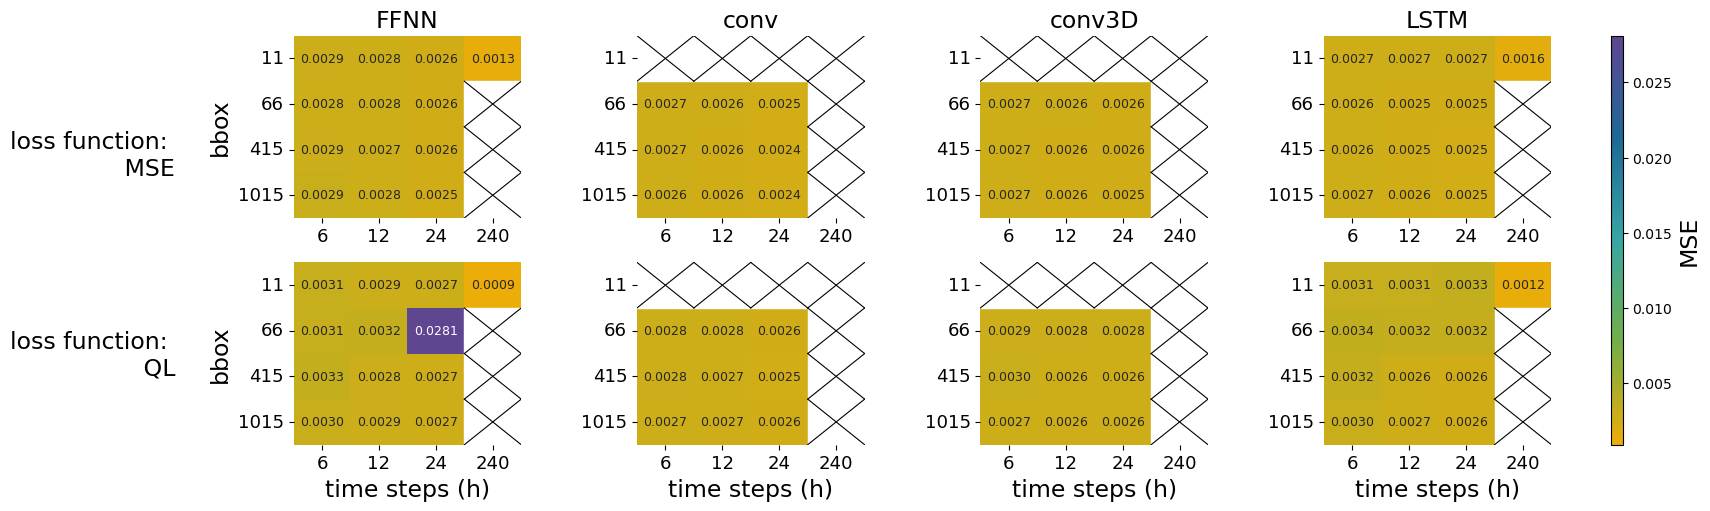

In [70]:
import seaborn as sns
import matplotlib.patches as patches 
# Creazione dei subplot
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_mse[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        #if n_matrici ==5:
        if len(loss_to_analyze) == 2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])

        mask = dataframes_mse[nome_df].isna()

        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_mse[nome_df],mask=mask, cmap=MSE_cmap, vmin=min_mse_heatmap, vmax=max_mse_heatmap, cbar=False, ax=ax, annot=True,fmt=".4f", annot_kws={"size": 9})
        elif case_of_study=="NY":
            heatmap_obj = sns.heatmap(dataframes_mse[nome_df],mask=mask,  cmap=MSE_cmap, vmin=min_mse_heatmap, vmax=max_mse_heatmap, cbar=False, ax=ax, annot=True,fmt=".4f", annot_kws={"size": 9})
        else:
            heatmap_obj = sns.heatmap(dataframes_mse[nome_df],mask=mask,  cmap=MSE_cmap, vmin=min_mse_heatmap, vmax=max_mse_heatmap, cbar=False, ax=ax, annot=True,fmt=".4f", annot_kws={"size": 9})


        # Aggiunta del riquadro e delle diagonali per le celle NaN
        for y in range(dataframes_qloss[nome_df].shape[0]):
            for x in range(dataframes_qloss[nome_df].shape[1]):
                if mask.iloc[y, x]:  # Se il valore è NaN
                    rect = patches.Rectangle((x, y), 1, 1, fill=False, edgecolor='w', lw=1)
                    ax.add_patch(rect)  # Aggiunge il riquadro

                    # Disegna le diagonali della cella (una X)
                    ax.plot([x, x + 1], [y, y + 1], color='black', lw=0.8)  # Diagonale \
                    ax.plot([x + 1, x], [y, y + 1], color='black', lw=0.8)  # Diagonale /

        if j ==0:
            ax.set_title(nomi_corretti_architetture[i], fontsize=17)
        if j ==1:  
            ax.set_xlabel('time steps (h)', fontsize=17)
        if i ==0:  
            ax.set_ylabel('bbox', fontsize=17)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13) 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    if title =="mse":
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n MSE"), va='center', ha='right', fontsize=17, rotation=0)
    else:
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n QL"), va='center', ha='right', fontsize=17, rotation=0)

# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
cbar = fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
cbar.set_label("MSE", fontsize=17) 
# fig.suptitle("mean squared error", fontsize=16)
# plt.show()
# plt.savefig("img_paper/heatmap_mse.pdf", format="pdf", bbox_inches="tight", dpi=400)
plt.show()

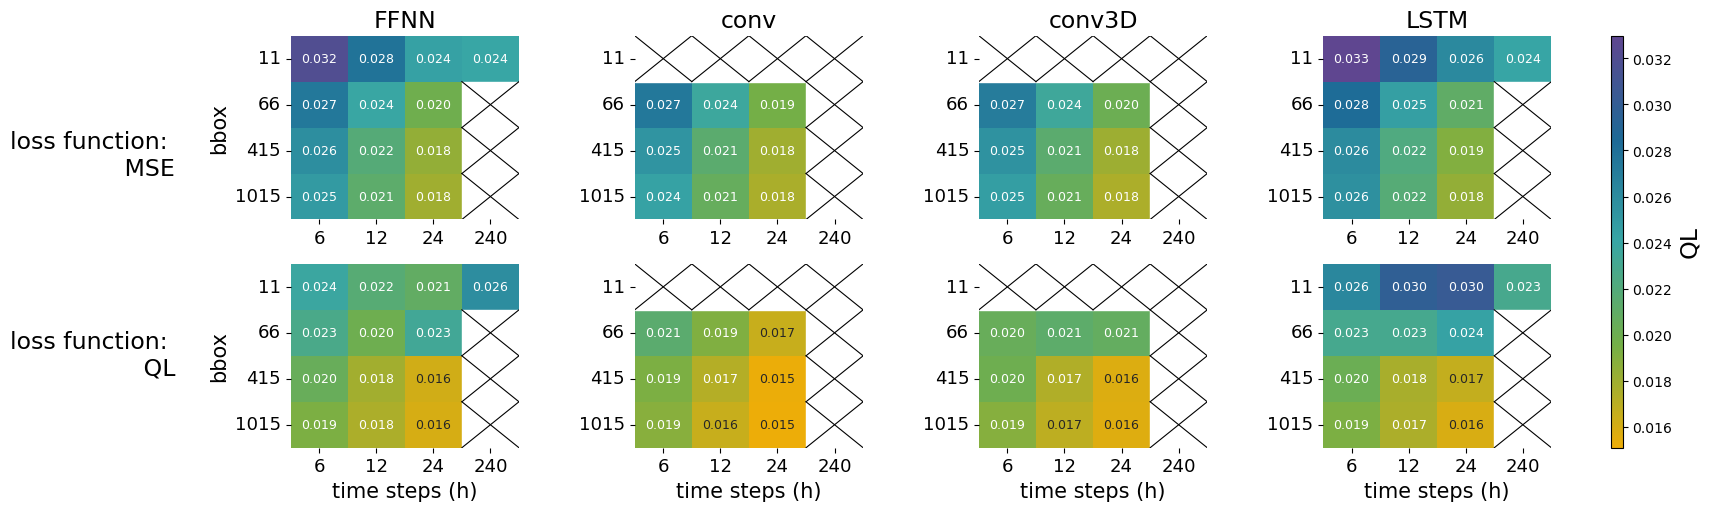

In [12]:
import seaborn as sns
import matplotlib.patches as patches 
# Creazione dei subplot
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_qloss[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) == 2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])

        mask = dataframes_qloss[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_qloss[nome_df],mask=mask, cmap=MSE_cmap, vmin=min_qloss_heatmap, vmax=0.2, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        if case_of_study=="NY":
            heatmap_obj = sns.heatmap(dataframes_qloss[nome_df],mask=mask,  cmap=MSE_cmap, vmin=min_qloss_heatmap, vmax=max_qloss_heatmap, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        else:
            heatmap_obj = sns.heatmap(dataframes_qloss[nome_df],mask=mask,  cmap=MSE_cmap, vmin=min_qloss_heatmap, vmax=max_qloss_heatmap, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        
        # Aggiunta del riquadro e delle diagonali per le celle NaN
        for y in range(dataframes_qloss[nome_df].shape[0]):
            for x in range(dataframes_qloss[nome_df].shape[1]):
                if mask.iloc[y, x]:  # Se il valore è NaN
                    rect = patches.Rectangle((x, y), 1, 1, fill=False, edgecolor='w', lw=1)
                    ax.add_patch(rect)  # Aggiunge il riquadro

                    # Disegna le diagonali della cella (una X)
                    ax.plot([x, x + 1], [y, y + 1], color='black', lw=0.8)  # Diagonale \
                    ax.plot([x + 1, x], [y, y + 1], color='black', lw=0.8)  # Diagonale /



        if j ==0:
            ax.set_title(nomi_corretti_architetture[i], fontsize=17)
        if j ==1:  
            ax.set_xlabel('time steps (h)', fontsize=15)
        if i ==0:  
            ax.set_ylabel('bbox', fontsize=15)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13) 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    if title =="mse":
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n MSE"), va='center', ha='right', fontsize=17, rotation=0)
    else:
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n QL"), va='center', ha='right', fontsize=17, rotation=0)

# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
cbar = fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
cbar.set_label("QL", fontsize=17) 
# fig.suptitle("Quantile loss", fontsize=19)
# plt.show()
plt.savefig("img_paper/heatmap_qloss.pdf", format="pdf", bbox_inches="tight", dpi=400)

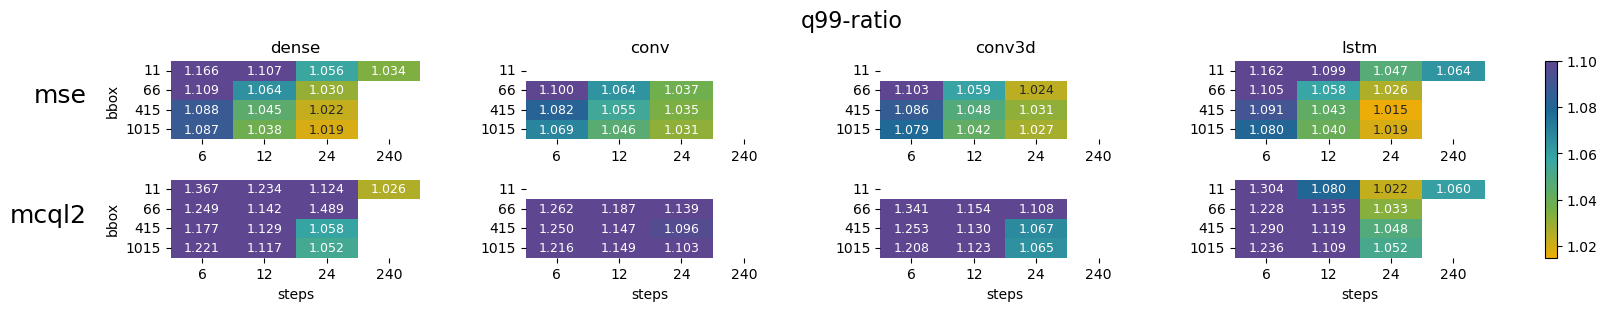

In [13]:
import seaborn as sns
# Creazione dei subplot
fig = plt.figure(figsize=(15, 3), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_qratio[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) == 2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])
        
        mask = dataframes_qratio[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_qratio[nome_df], mask=mask, cmap=MSE_cmap, vmin=min_qratio_heatmap, vmax=1.1, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        if case_of_study=="NY":
            heatmap_obj = sns.heatmap(dataframes_qratio[nome_df], mask=mask,  cmap=MSE_cmap, vmin=min_qratio_heatmap, vmax=1.1, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        else:
            heatmap_obj = sns.heatmap(dataframes_qratio[nome_df], mask=mask,  cmap=MSE_cmap, vmin=min_qratio_heatmap, vmax=max_qratio_heatmap, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})

        if j ==0:
            ax.set_title(archit_to_analyze[i])
        if j ==1:  
            ax.set_xlabel('steps')
        if i ==0:  
            ax.set_ylabel('bbox')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    fig.text(-0.01, 0.7 - i * 0.4, title, va='center', ha='right', fontsize=18, rotation=0)


# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
fig.suptitle("q99-ratio", fontsize=16)
plt.show()

## Extremes analisys

## __________________________________________________________________________________________________________

In [14]:
include_test = True

y10RP_surge_scores = []
y100RP_surge_scores = []

def generate_hourly_dates(start_year, start_month, end_year, end_month):
    # Genera una data di inizio e una data di fine
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
    # Calcola l'ultimo giorno del mese di fine
    end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
    
    # Genera il vettore di date con passo orario
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    return date_range

date_extremes_pred = [[],[],[],[],[]]
date_extremes_real = [[],[],[],[],[]]
exceedances_pred = [[],[],[],[],[]]
exceedances_real = [[],[],[],[],[]]

k = 0
for fold in range(1):
    k = k+1
    y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_train= np.load(y_train_name)
    if preprocess=="standardize":
        y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_val=np.load(y_val_name)
    if preprocess=="standardize":
        y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_test=np.load(y_test_name)
    if preprocess=="standardize":
        y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

    # quantile for exceedances threshold
    y= np.concatenate([y_train, y_val, y_test])
    y_cleaned = y[:,1]
    y_cleaned = y_cleaned[~np.isnan(y_cleaned)]
    threshold_surge = np.quantile(y_cleaned, 0.99)
    del y_cleaned

# Generazione del vettore di date
start_year = train_y_bounds[0]
start_month = train_month_start_end[0]
end_year = train_y_bounds[1]
end_month = train_month_start_end[1]
dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
# (mancano steps recurrent iniziali)
# dates = dates[(LSTM_recurrent_steps-1):]

palette_list= [palette_hex_list[1],palette_hex_list[3],palette_hex_list[5],palette_hex_list[7],palette_hex_list[9]]

# Creazione dei subplot
# fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)
adjust_len=0
for i, model_type in enumerate(models_to_analyze):
    model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
    file_exists = os.path.isdir(model_path)
    if (file_exists) ==False:   
        y10RP_surge_scores.append(np.nan)
        y100RP_surge_scores.append(np.nan)
        adjust_len=adjust_len+1

    else:            
        i=i-adjust_len
        train_val_indices = np.load(local_data_path+'train_val_indices.npy')
        test_indices = np.load(local_data_path+'test_indices.npy')
        arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
        arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
        color = palette_list[i % len(palette_list)]  # Cicla attraverso i colori
        
        k = 0
        for fold in range(folds_number):
            k = k+1
            
            
            # Caricamento dei valori inferiti
            y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
            y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
            y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
            if preprocess=="standardize":
                y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            if preprocess=="standardize":
                y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            if preprocess=="standardize":
                y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

            y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_train= np.load(y_train_name)
            if preprocess=="standardize":
                y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_val=np.load(y_val_name)
            if preprocess=="standardize":
                y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_test=np.load(y_test_name)
            if preprocess=="standardize":
                y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

            # Considera solo la seconda variabile
            y_train_predict = y_train_predict[:, 1]
            y_val_predict = y_val_predict[:, 1]
            y_test_predict = y_test_predict[:, 1]

            # Combinazione delle predizioni
            if include_test:
                y_predict = np.concatenate([y_val_predict, y_test_predict])
                y_real = np.concatenate([y_val[:, 1], y_test[:, 1]])
            else:
                y_predict = y_val_predict
                y_real = y_val[:, 1]
                
            # Usa gli indici generati da KFold per creare i set di training e validation
            dates_test = dates[test_indices]
            train_array_name = f'train_indices_fold_{k}'
            val_array_name = f'val_indices_fold_{k}'
            dates_train, dates_val = dates[arrays_train_indicies[train_array_name].astype(int)], dates[arrays_val_indicies[val_array_name].astype(int)]
            
            if include_test:
                dates_concat = np.concatenate([dates_val, dates_test], axis=0)

            else:
                dates_concat = dates_val
            
            # print("dates len: "+str(dates_concat.shape))
            # print("y_predict len: "+str(y_predict.shape))
            
            
            # Creazione del DataFrame per i valori predetti
            ts = pd.Series(data=y_predict, index=dates_concat)
            # extremes = get_extremes(ts, "POT", threshold=threshold_surge, r="24h")
            exceedances_pred[fold].append(ts.values)
            date_extremes_pred[fold].append(ts.index)

            # # Creazione del DataFrame per i valori reali
            ts_real = pd.Series(data=y_real, index=dates_concat)
            # extremes = get_extremes(ts_real, "POT", threshold=threshold_surge, r="24h")
            exceedances_real[fold].append(ts_real.values)
            date_extremes_real[fold].append(ts_real.index)
            



        flaten_date_extremes_pred = np.concatenate((
            date_extremes_pred[0][i],
            date_extremes_pred[1][i],
            date_extremes_pred[2][i],
            date_extremes_pred[3][i],
            date_extremes_pred[4][i]
        ),axis=0)

        flaten_date_extremes_real = np.concatenate((
            date_extremes_real[0][i],
            date_extremes_real[1][i],
            date_extremes_real[2][i],
            date_extremes_real[3][i],
            date_extremes_real[4][i]
        ),axis=0)

        flaten_exceedance_pred = np.concatenate((
            exceedances_pred[0][i],
            exceedances_pred[1][i],
            exceedances_pred[2][i],
            exceedances_pred[3][i],
            exceedances_pred[4][i]
        ),axis=0)

        flaten_exceedance_real = np.concatenate((
            exceedances_real[0][i],
            exceedances_real[1][i],
            exceedances_real[2][i],
            exceedances_real[3][i],
            exceedances_real[4][i]
        ),axis=0)

        threshold_surge_pred = np.quantile(flaten_exceedance_pred, 0.99)
        # Fitting della distribuzione GPD ai valori sopra la soglia
        
        ts_real = pd.Series(data=flaten_exceedance_real, index=flaten_date_extremes_real)
        ts_real = ts_real.groupby(ts_real.index).mean()
        ts_real = ts_real.sort_index()
        model_real = EVA(ts_real)
        model_real.get_extremes( "POT", threshold=threshold_surge, r="24h")
        model_real.fit_model()
        rp_real = model_real.get_summary(
                                            return_period=[10,100, 500, 1000, 10000],
                                            alpha=0.90,
                                            n_samples=1000,
                                        )

        ts_pred = pd.Series(data=flaten_exceedance_pred, index=flaten_date_extremes_pred)
        ts_pred = ts_pred.groupby(ts_pred.index).mean()
        ts_pred = ts_pred.sort_index()
        model_pred = EVA(ts_pred)
        model_pred.get_extremes( "POT", threshold=threshold_surge_pred, r="24h")
        model_pred.fit_model()
        rp_pred = model_pred.get_summary(
                                            return_period=[10,100, 500, 1000, 10000],
                                            alpha=0.90,
                                            n_samples=1000,
                                        )

        #______________________COMPUTE_J-S_DIVERGENCE______________________________________
        #__________________________________________________________________________________

        y10RP_surge_scores.append(rp_pred.values[0,0] - rp_real.values[0,0])
        y100RP_surge_scores.append(rp_pred.values[1,0] - rp_real.values[1,0])

    #__________________________________________________________________________________
    

In [15]:
# model_real.plot_diagnostic( alpha=0.90,
#                             n_samples=1000,
#                             )

In [16]:
include_test = True

y10RP_total_scores = []
y100RP_total_scores = []

def generate_hourly_dates(start_year, start_month, end_year, end_month):
    # Genera una data di inizio e una data di fine
    start_date = pd.Timestamp(year=start_year, month=start_month, day=1, hour=0, minute=0)
    # Calcola l'ultimo giorno del mese di fine
    end_date = pd.Timestamp(year=end_year, month=end_month, day=1, hour=0, minute=0) + pd.offsets.MonthEnd(0) + pd.DateOffset(hour=23, minute=59)
    
    # Genera il vettore di date con passo orario
    date_range = pd.date_range(start=start_date, end=end_date, freq='h')
    return date_range

date_extremes_pred = [[],[],[],[],[]]
date_extremes_real = [[],[],[],[],[]]
exceedances_pred = [[],[],[],[],[]]
exceedances_real = [[],[],[],[],[]]

k = 0
for fold in range(1):
    k = k+1
    y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_train= np.load(y_train_name)
    if preprocess=="standardize":
        y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_val=np.load(y_val_name)
    if preprocess=="standardize":
        y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
    y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
    y_test=np.load(y_test_name)
    if preprocess=="standardize":
        y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
        y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

    # quantile for exceedances threshold
    y= np.concatenate([y_train, y_val, y_test])
    y_cleaned = y[:,1]+y[:,0]
    y_cleaned = y_cleaned[~np.isnan(y_cleaned)]
    threshold_surge = np.quantile(y_cleaned, 0.99)
    del y_cleaned

# Generazione del vettore di date
start_year = train_y_bounds[0]
start_month = train_month_start_end[0]
end_year = train_y_bounds[1]
end_month = train_month_start_end[1]
dates = generate_hourly_dates(start_year, start_month, end_year, end_month)
# (mancano steps recurrent iniziali)
# dates = dates[(LSTM_recurrent_steps-1):]

palette_list= [palette_hex_list[1],palette_hex_list[3],palette_hex_list[5],palette_hex_list[7],palette_hex_list[9]]

# Creazione dei subplot
# fig, axs = plt.subplots(2, 2, figsize=(15, 7), constrained_layout=True)

adjust_len=0
for i, model_type in enumerate(models_to_analyze):
    model_path = output_path+"surrogate_GTSM_model/models/"+model_type+"_"+preprocess+"_model/"
    file_exists = os.path.isdir(model_path)
    if (file_exists) ==False:   
        y10RP_total_scores.append(np.nan)
        y100RP_total_scores.append(np.nan)
        adjust_len=adjust_len+1

    else:    
        i=i-adjust_len        
        train_val_indices = np.load(local_data_path+'train_val_indices.npy')
        test_indices = np.load(local_data_path+'test_indices.npy')
        arrays_train_indicies = np.load(local_data_path+'arrays_train_indicies.npy', allow_pickle=True).item()
        arrays_val_indicies = np.load(local_data_path+'arrays_val_indicies.npy', allow_pickle=True).item()
        color = palette_list[i % len(palette_list)]  # Cicla attraverso i colori
        
        k = 0
        for fold in range(folds_number):
            k = k+1
            
            
            # Caricamento dei valori inferiti
            y_train_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_train_k"+str(fold)+"_predict.npy")
            y_val_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_val_k"+str(fold)+"_predict.npy")
            y_test_predict = np.load(output_path + f"surrogate_GTSM_model/models/{model_type}_"+preprocess+"_model/y_test_k"+str(fold)+"_predict.npy")
            if preprocess=="standardize":
                y_train_predict[:,0] = y_train_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_train_predict[:,1] = y_train_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            if preprocess=="standardize":
                y_val_predict[:,0] = y_val_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_val_predict[:,1] = y_val_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            if preprocess=="standardize":
                y_test_predict[:,0] = y_test_predict[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_test_predict[:,1] = y_test_predict[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

            y_train_name= output_path+'surrogate_GTSM_model/model_input_output/y_train_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_train= np.load(y_train_name)
            if preprocess=="standardize":
                y_train[:,0] = y_train[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_train[:,1] = y_train[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            y_val_name= output_path+'surrogate_GTSM_model/model_input_output/y_val_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_val=np.load(y_val_name)
            if preprocess=="standardize":
                y_val[:,0] = y_val[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_val[:,1] = y_val[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])
            y_test_name= output_path+'surrogate_GTSM_model/model_input_output/y_test_k'+str(fold)+'_'+preprocess+'_'+str(train_y_bounds[0])+'_'+str(train_y_bounds[1])+'_lat_'+str(lat)+'_lon_'+str(lon)+'_shape_'+str(y_shape)+'_.npy'
            y_test=np.load(y_test_name)
            if preprocess=="standardize":
                y_test[:,0] = y_test[:,0]*(kfold_global_std[fold][0][-2])+(kfold_global_mean[fold][0][-2])
                y_test[:,1] = y_test[:,1]*(kfold_global_std[fold][0][-1])+(kfold_global_mean[fold][0][-1])

            # Considera solo la seconda variabile
            y_train_predict = y_train_predict[:, 1]+y_train_predict[:, 0]
            y_val_predict = y_val_predict[:, 1]+y_val_predict[:, 0]
            y_test_predict = y_test_predict[:, 1]+y_test_predict[:, 0]

            # Combinazione delle predizioni
            if include_test:
                y_predict = np.concatenate([y_val_predict, y_test_predict])
                y_real = np.concatenate([y_val[:, 1]+y_val[:, 0], y_test[:, 1]+y_test[:, 0]])
            else:
                y_predict = y_val_predict
                y_real = y_val[:, 1]+y_val[:, 0]
                
            # Usa gli indici generati da KFold per creare i set di training e validation
            dates_test = dates[test_indices]
            train_array_name = f'train_indices_fold_{k}'
            val_array_name = f'val_indices_fold_{k}'
            dates_train, dates_val = dates[arrays_train_indicies[train_array_name].astype(int)], dates[arrays_val_indicies[val_array_name].astype(int)]
            
            if include_test:
                dates_concat = np.concatenate([dates_val, dates_test], axis=0)

            else:
                dates_concat = dates_val
            
       # print("dates len: "+str(dates_concat.shape))
            # print("y_predict len: "+str(y_predict.shape))
            
            
            # Creazione del DataFrame per i valori predetti
            ts = pd.Series(data=y_predict, index=dates_concat)
            # extremes = get_extremes(ts, "POT", threshold=threshold_surge, r="24h")
            exceedances_pred[fold].append(ts.values)
            date_extremes_pred[fold].append(ts.index)

            # # Creazione del DataFrame per i valori reali
            ts_real = pd.Series(data=y_real, index=dates_concat)
            # extremes = get_extremes(ts_real, "POT", threshold=threshold_surge, r="24h")
            exceedances_real[fold].append(ts_real.values)
            date_extremes_real[fold].append(ts_real.index)
            



        flaten_date_extremes_pred = np.concatenate((
            date_extremes_pred[0][i],
            date_extremes_pred[1][i],
            date_extremes_pred[2][i],
            date_extremes_pred[3][i],
            date_extremes_pred[4][i]
        ),axis=0)

        flaten_date_extremes_real = np.concatenate((
            date_extremes_real[0][i],
            date_extremes_real[1][i],
            date_extremes_real[2][i],
            date_extremes_real[3][i],
            date_extremes_real[4][i]
        ),axis=0)

        flaten_exceedance_pred = np.concatenate((
            exceedances_pred[0][i],
            exceedances_pred[1][i],
            exceedances_pred[2][i],
            exceedances_pred[3][i],
            exceedances_pred[4][i]
        ),axis=0)

        flaten_exceedance_real = np.concatenate((
            exceedances_real[0][i],
            exceedances_real[1][i],
            exceedances_real[2][i],
            exceedances_real[3][i],
            exceedances_real[4][i]
        ),axis=0)

        threshold_surge_pred = np.quantile(flaten_exceedance_pred, 0.99)
        # Fitting della distribuzione GPD ai valori sopra la soglia
        
        ts_real = pd.Series(data=flaten_exceedance_real, index=flaten_date_extremes_real)
        ts_real = ts_real.groupby(ts_real.index).mean()
        ts_real = ts_real.sort_index()
        model_real = EVA(ts_real)
        model_real.get_extremes( "POT", threshold=threshold_surge, r="24h")
        model_real.fit_model()
        rp_real = model_real.get_summary(
                                            return_period=[10,100, 500, 1000, 10000],
                                            alpha=0.90,
                                            n_samples=1000,
                                        )

        ts_pred = pd.Series(data=flaten_exceedance_pred, index=flaten_date_extremes_pred)
        ts_pred = ts_pred.groupby(ts_pred.index).mean()
        ts_pred = ts_pred.sort_index()
        model_pred = EVA(ts_pred)
        model_pred.get_extremes( "POT", threshold=threshold_surge_pred, r="24h")
        model_pred.fit_model()
        rp_pred = model_pred.get_summary(
                                            return_period=[10,100, 500, 1000, 10000],
                                            alpha=0.90,
                                            n_samples=1000,
                                        )

        #______________________COMPUTE_J-S_DIVERGENCE______________________________________
        #__________________________________________________________________________________

        y10RP_total_scores.append(rp_pred.values[0,0] - rp_real.values[0,0])
        y100RP_total_scores.append(rp_pred.values[1,0] - rp_real.values[1,0])
        
    #__________________________________________________________________________________


In [17]:
df_JSS = pd.DataFrame({
    'models': models_to_analyze, 
    'JS_gev_surge': y10RP_surge_scores,    
    'JS_gpd_surge': y100RP_surge_scores,  
    'JS_gev_wl': y10RP_total_scores,  
    'JS_gpd_wl': y100RP_total_scores,  
})

max_JS_gev_surge = np.nan
min_JS_gev_surge = np.nan
max_JS_gpd_surge = np.nan
min_JS_gpd_surge = np.nan
max_JS_gev_wl = np.nan
min_JS_gev_wl = np.nan
max_JS_gpd_wl = np.nan
min_JS_gpd_wl = np.nan

# Dizionario per salvare i DataFrame
dataframes_JS_gev_surge= {}
dataframes_JS_gpd_surge = {}
dataframes_JS_gev_wl = {}
dataframes_JS_gpd_wl = {}

#n_matrici = len(archit_to_analyze)*len(loss_to_analyze)
n_matrici = len(archit_to_analyze)

# Creazione dei DataFrame
for i in range(n_matrici):
    for j in range(len(loss_to_analyze)):
        # Creare un DataFrame vuoto con nomi delle righe
        df_JS_gev_surge_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)
        df_JS_gpd_surge_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)
        df_JS_gev_wl_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)
        df_JS_gpd_wl_tmp = pd.DataFrame(np.nan, index=bbox_to_analyze, columns=steps_to_analyze)

        for k in range(len(bbox_to_analyze)):
            for w in range(len(steps_to_analyze)):

                # Lista di sottostringhe da cercare
                substrings = [archit_to_analyze[i],loss_to_analyze[j], f'bbox{bbox_to_analyze[k]}', f'steps{steps_to_analyze[w]}']
                # Seleziona le stringhe che contengono tutte le sottostringhe
                substring_result = [s for s in models_to_analyze if all(sub in s for sub in substrings)]
                
                df_JS_gev_surge_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] =  df_JSS.loc[df_JSS['models'] == substring_result[0], 'JS_gev_surge'].values[0]
                df_JS_gpd_surge_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] =  df_JSS.loc[df_JSS['models'] == substring_result[0], 'JS_gpd_surge'].values[0]
                df_JS_gev_wl_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] =  df_JSS.loc[df_JSS['models'] == substring_result[0], 'JS_gev_wl'].values[0]
                df_JS_gpd_wl_tmp.loc[bbox_to_analyze[k], steps_to_analyze[w]] =  df_JSS.loc[df_JSS['models'] == substring_result[0], 'JS_gpd_wl'].values[0]


        if np.isnan(max_JS_gev_surge):
            max_JS_gev_surge = df_JS_gev_surge_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_JS_gev_surge):
            min_JS_gev_surge = df_JS_gev_surge_tmp.min(skipna=True).min(skipna=True)
        if df_JS_gev_surge_tmp.max(skipna=True).max(skipna=True) >= max_JS_gev_surge:
            max_JS_gev_surge = df_JS_gev_surge_tmp.max(skipna=True).max(skipna=True)
        if df_JS_gev_surge_tmp.min(skipna=True).min(skipna=True) <= min_JS_gev_surge:
            min_JS_gev_surge = df_JS_gev_surge_tmp.min(skipna=True).min(skipna=True)

        if np.isnan(max_JS_gpd_surge):
            max_JS_gpd_surge = df_JS_gpd_surge_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_JS_gpd_surge):
            min_JS_gpd_surge = df_JS_gpd_surge_tmp.min(skipna=True).min(skipna=True)
        if df_JS_gpd_surge_tmp.max(skipna=True).max(skipna=True) >= max_JS_gpd_surge:
            max_JS_gpd_surge = df_JS_gpd_surge_tmp.max(skipna=True).max(skipna=True)
        if df_JS_gpd_surge_tmp.min(skipna=True).min(skipna=True) <= min_JS_gpd_surge:
            min_JS_gpd_surge = df_JS_gpd_surge_tmp.min(skipna=True).min(skipna=True)

        if np.isnan(max_JS_gev_wl):
            max_JS_gev_wl = df_JS_gev_wl_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_JS_gev_wl):
            min_JS_gev_wl = df_JS_gev_wl_tmp.min(skipna=True).min(skipna=True)
        if df_JS_gev_wl_tmp.max(skipna=True).max(skipna=True) >= max_JS_gev_wl:
            max_JS_gev_wl = df_JS_gev_wl_tmp.max(skipna=True).max(skipna=True)
        if df_JS_gev_wl_tmp.min(skipna=True).min(skipna=True) <= min_JS_gev_wl:
            min_JS_gev_wl = df_JS_gev_wl_tmp.min(skipna=True).min(skipna=True)

        if np.isnan(max_JS_gpd_wl):
            max_JS_gpd_wl = df_JS_gpd_wl_tmp.max(skipna=True).max(skipna=True)
        if np.isnan(min_JS_gpd_wl):
            min_JS_gpd_wl = df_JS_gpd_wl_tmp.min(skipna=True).min(skipna=True)
        if df_JS_gpd_wl_tmp.max(skipna=True).max(skipna=True) >= max_JS_gpd_wl:
            max_JS_gpd_wl = df_JS_gpd_wl_tmp.max(skipna=True).max(skipna=True)
        if df_JS_gpd_wl_tmp.min(skipna=True).min(skipna=True) <= min_JS_gpd_wl:
            min_JS_gpd_wl = df_JS_gpd_wl_tmp.min(skipna=True).min(skipna=True)
            
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_JS_gev_surge[nome_df] = df_JS_gev_surge_tmp
        dataframes_JS_gpd_surge[nome_df] = df_JS_gpd_surge_tmp
        dataframes_JS_gev_wl[nome_df] = df_JS_gev_wl_tmp
        dataframes_JS_gpd_wl[nome_df] = df_JS_gpd_wl_tmp

In [21]:
import matplotlib
print(matplotlib.__version__)


3.8.4


In [24]:
max_JS_gpd_surge

0.2228489633621089

In [35]:
from matplotlib.colors import TwoSlopeNorm


def make_symmetric_cmap(base_cmap, base_cmap_2, n_colors=256):
    half = n_colors // 2
    cmap_r = base_cmap.reversed()(np.linspace(0, 1, half))
    cmap_f = base_cmap_2(np.linspace(0, 1, half))
    colors = np.vstack((cmap_r, cmap_f))
    return LinearSegmentedColormap.from_list("symmetric_cmap", colors)

symmetric_cmap = make_symmetric_cmap(MSE_cmap, MSE_cmap_2)






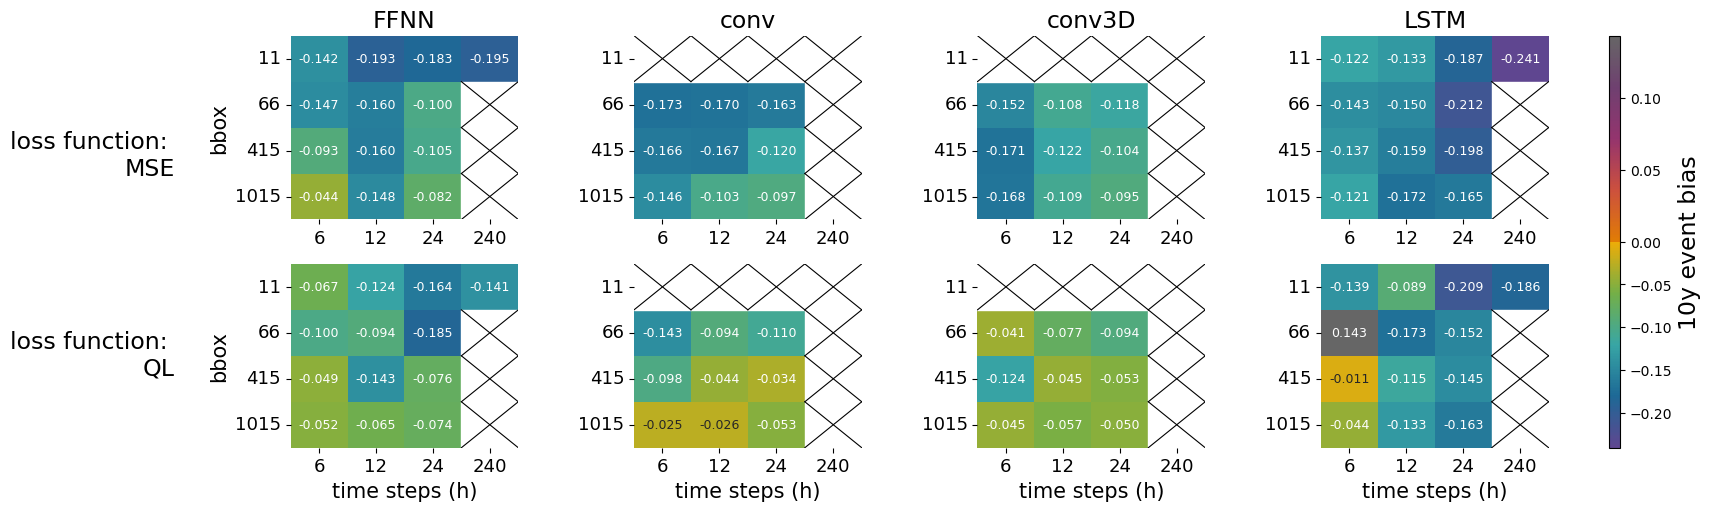

In [36]:
import seaborn as sns
import matplotlib.patches as patches 
# Creazione dei subplot
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)
norm = TwoSlopeNorm(vmin=min_JS_gev_surge, vcenter=0, vmax=max_JS_gev_surge)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_JS_gev_surge[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) ==2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])
        
        mask = dataframes_JS_gev_surge[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_JS_gev_surge[nome_df], mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gev_surge, vmax=-0.011, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        if case_of_study=="NY":
            # heatmap_obj = sns.heatmap(dataframes_JS_gev_surge[nome_df],mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gev_surge, vmax=-0.011, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
            heatmap_obj = sns.heatmap(
                                        dataframes_JS_gev_surge[nome_df],
                                        mask=mask,
                                        cmap=symmetric_cmap,
                                        norm=norm,
                                        cbar=False,
                                        ax=ax,
                                        annot=True,
                                        fmt=".3f",
                                        annot_kws={"size": 9}
                                    )


        else:
            heatmap_obj = sns.heatmap(dataframes_JS_gev_surge[nome_df],mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gev_surge, vmax=-0.011, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})

        # Aggiunta del riquadro e delle diagonali per le celle NaN
        for y in range(dataframes_qloss[nome_df].shape[0]):
            for x in range(dataframes_qloss[nome_df].shape[1]):
                if mask.iloc[y, x]:  # Se il valore è NaN
                    rect = patches.Rectangle((x, y), 1, 1, fill=False, edgecolor='w', lw=1)
                    ax.add_patch(rect)  # Aggiunge il riquadro

                    # Disegna le diagonali della cella (una X)
                    ax.plot([x, x + 1], [y, y + 1], color='black', lw=0.8)  # Diagonale \
                    ax.plot([x + 1, x], [y, y + 1], color='black', lw=0.8)  # Diagonale /

        if j ==0:
            ax.set_title(nomi_corretti_architetture[i], fontsize=17)
        if j ==1:  
            ax.set_xlabel('time steps (h)', fontsize=15)
        if i ==0:  
            ax.set_ylabel('bbox', fontsize=15)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13) 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    if title =="mse":
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \nMSE"), va='center', ha='right', fontsize=17, rotation=0)
    else:
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \nQL"), va='center', ha='right', fontsize=17, rotation=0)

# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
cbar = fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
cbar.set_label("10y event bias", fontsize=17) 
# fig.suptitle("bias", fontsize=19)
# plt.show()
plt.savefig("img_paper/heatmap_10yevent.pdf", format="pdf", bbox_inches="tight", dpi=400)


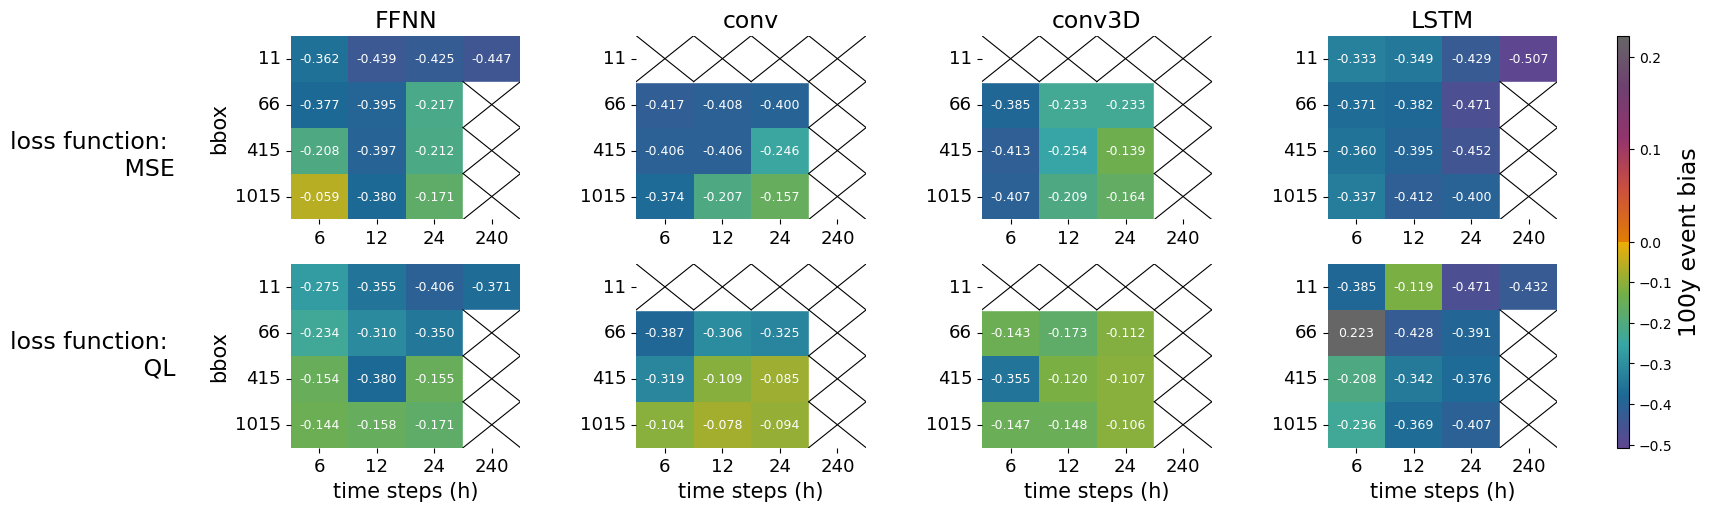

In [37]:
import seaborn as sns
import matplotlib.patches as patches 
# Creazione dei subplot
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)
norm = TwoSlopeNorm(vmin=min_JS_gpd_surge, vcenter=0, vmax=max_JS_gpd_surge)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_JS_gpd_surge[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) ==2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])
        
        mask = dataframes_JS_gpd_surge[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_JS_gpd_surge[nome_df], mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gpd_surge, vmax=-0.059, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        if case_of_study=="NY":
            # heatmap_obj = sns.heatmap(dataframes_JS_gpd_surge[nome_df],mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gpd_surge, vmax=-0.059, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
            heatmap_obj = sns.heatmap(
                                        dataframes_JS_gpd_surge[nome_df],
                                        mask=mask,
                                        cmap=symmetric_cmap,
                                        norm=norm,
                                        cbar=False,
                                        ax=ax,
                                        annot=True,
                                        fmt=".3f",
                                        annot_kws={"size": 9}
                                    )
        else:    
            heatmap_obj = sns.heatmap(dataframes_JS_gpd_surge[nome_df],mask=mask, cmap=MSE_cmap.reversed(), vmin=min_JS_gpd_surge, vmax=-0.059, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
      
      
        # Aggiunta del riquadro e delle diagonali per le celle NaN
        for y in range(dataframes_qloss[nome_df].shape[0]):
            for x in range(dataframes_qloss[nome_df].shape[1]):
                if mask.iloc[y, x]:  # Se il valore è NaN
                    rect = patches.Rectangle((x, y), 1, 1, fill=False, edgecolor='w', lw=1)
                    ax.add_patch(rect)  # Aggiunge il riquadro

                    # Disegna le diagonali della cella (una X)
                    ax.plot([x, x + 1], [y, y + 1], color='black', lw=0.8)  # Diagonale \
                    ax.plot([x + 1, x], [y, y + 1], color='black', lw=0.8)  # Diagonale /

        if j ==0:
            ax.set_title(nomi_corretti_architetture[i], fontsize=17)
        if j ==1:  
            ax.set_xlabel('time steps (h)', fontsize=15)
        if i ==0:  
            ax.set_ylabel('bbox', fontsize=15)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13) 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    if title =="mse":
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n MSE"), va='center', ha='right', fontsize=17, rotation=0)
    else:
        fig.text(-0.02, 0.7 - i * 0.4, str("loss function: \n QL"), va='center', ha='right', fontsize=17, rotation=0)

# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
cbar = fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
cbar.set_label("100y event bias", fontsize=17) 
# fig.suptitle("bias", fontsize=19)
# plt.show()
plt.savefig("img_paper/heatmap_100yevent.pdf", format="pdf", bbox_inches="tight", dpi=400)

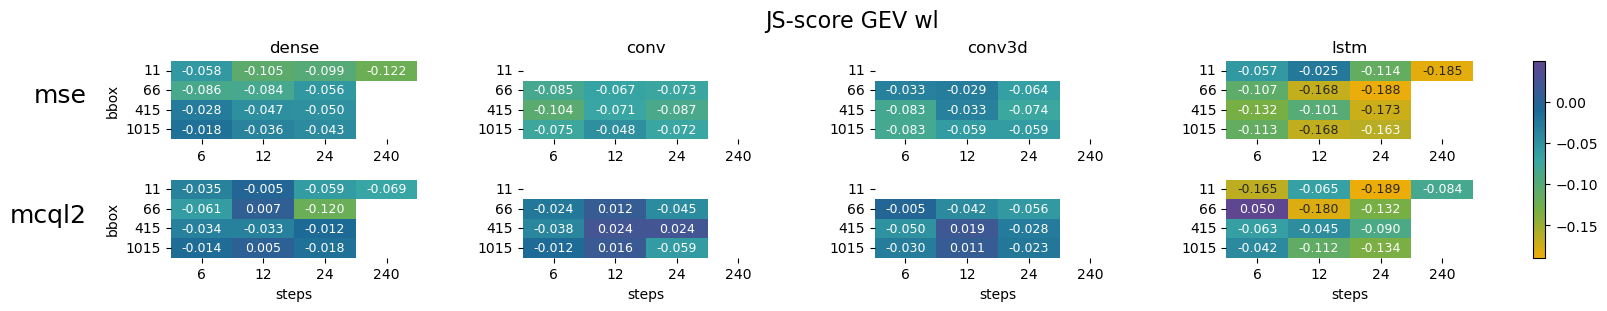

In [31]:
import seaborn as sns
# Creazione dei subplot
fig = plt.figure(figsize=(15, 3), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_JS_gev_wl[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) ==2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])
        
        mask = dataframes_JS_gev_wl[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_JS_gev_wl[nome_df], mask=mask, cmap=MSE_cmap, vmin=min_JS_gev_wl, vmax=max_JS_gev_wl, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        if case_of_study=="NY":
            heatmap_obj = sns.heatmap(dataframes_JS_gev_wl[nome_df],mask=mask,  cmap=MSE_cmap, vmin=min_JS_gev_wl, vmax=max_JS_gev_wl, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
                
        else:    
            heatmap_obj = sns.heatmap(dataframes_JS_gev_wl[nome_df], mask=mask, cmap=MSE_cmap, vmin=min_JS_gev_wl, vmax=max_JS_gev_wl, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})

        if j ==0:
            ax.set_title(archit_to_analyze[i])
        if j ==1:  
            ax.set_xlabel('steps')
        if i ==0:  
            ax.set_ylabel('bbox')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    fig.text(-0.01, 0.7 - i * 0.4, title, va='center', ha='right', fontsize=18, rotation=0)


# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
fig.suptitle("JS-score GEV wl", fontsize=16)
plt.show()

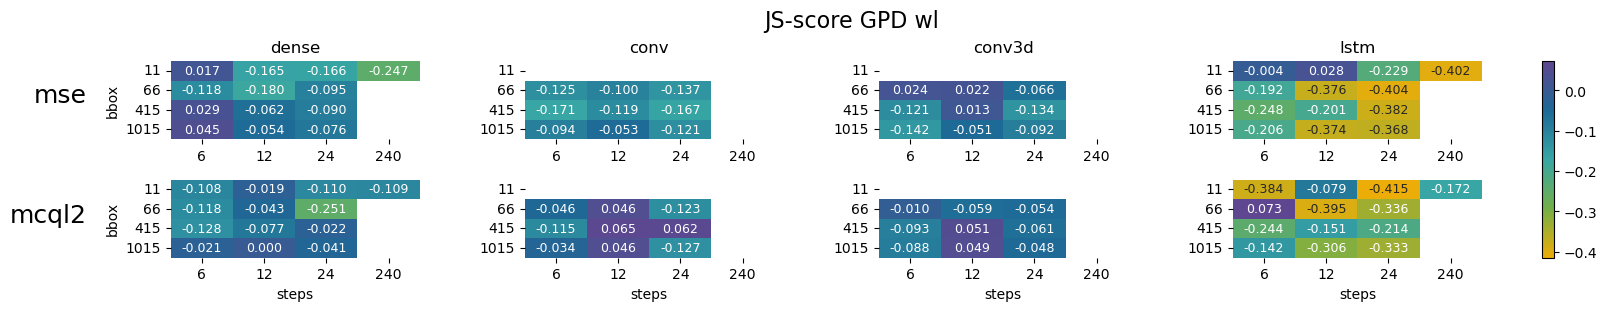

In [32]:
import seaborn as sns
# Creazione dei subplot
fig = plt.figure(figsize=(15, 3), constrained_layout=True)
# Crea una griglia con len(loss_to_analyze) righe, len(archit_to_analyze) colonne e una colonna extra per la colorbar
gs = gridspec.GridSpec(len(loss_to_analyze), len(archit_to_analyze) + 1, figure=fig,width_ratios=[1] * len(archit_to_analyze) + [0.05], wspace=0.2)

# Creazione dei DataFrame
for j in range(len(loss_to_analyze)):
    for i in range(n_matrici):
    
        
        nome_df = f'df_{archit_to_analyze[i]}_{loss_to_analyze[j]}'
        dataframes_JS_gpd_wl[nome_df]

        # Assegna i subplot alla griglia, lasciando l'ultima colonna per la colorbar
        if len(loss_to_analyze) ==2:
            ax = fig.add_subplot(gs[j, i])
        else:
            ax = fig.add_subplot(gs[i])
        
        mask = dataframes_JS_gpd_wl[nome_df].isna()
        # Configurazione del grafico delle distribuzioni GEV
        if case_of_study=="BEIRA":
            heatmap_obj = sns.heatmap(dataframes_JS_gpd_wl[nome_df], mask=mask, cmap=MSE_cmap, vmin=min_JS_gpd_wl, vmax=max_JS_gpd_wl, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})
        
        heatmap_obj = sns.heatmap(dataframes_JS_gpd_wl[nome_df], mask=mask, cmap=MSE_cmap, vmin=min_JS_gpd_wl, vmax=max_JS_gpd_wl, cbar=False, ax=ax, annot=True,fmt=".3f", annot_kws={"size": 9})

        if j ==0:
            ax.set_title(archit_to_analyze[i])
        if j ==1:  
            ax.set_xlabel('steps')
        if i ==0:  
            ax.set_ylabel('bbox')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 

# Aggiunta di un titolo per ogni riga a sinistra della figura
for i, title in enumerate(loss_to_analyze):
    fig.text(-0.01, 0.7 - i * 0.4, title, va='center', ha='right', fontsize=18, rotation=0)


# Aggiungere una colorbar condivisa per tutte le heatmap nella colonna extra
cbar_ax = fig.add_subplot(gs[:, -1])  # Usa l'ultima colonna della griglia per la colorbar
fig.colorbar(heatmap_obj.collections[0], cax=cbar_ax, shrink=1.4)
fig.suptitle("JS-score GPD wl", fontsize=16)
plt.show()